In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TimeDistributed
from tensorflow.keras.utils import to_categorical
import pickle

# Load dataset
df = pd.read_csv('/content/pos_tagged_marathi.csv')
sentences = df['Tokenized Sentence'].apply(str.split).tolist()
tags = df['POS Tags'].apply(str.split).tolist()

# Tokenizers
word_tokenizer = Tokenizer(lower=False, filters='')
word_tokenizer.fit_on_texts(sentences)
X = word_tokenizer.texts_to_sequences(sentences)

tag_tokenizer = Tokenizer(lower=False, filters='')
tag_tokenizer.fit_on_texts(tags)
y = tag_tokenizer.texts_to_sequences(tags)

# Padding
max_len = max(len(seq) for seq in X)
X = pad_sequences(X, maxlen=max_len, padding='post')
y = pad_sequences(y, maxlen=max_len, padding='post')
y = to_categorical(y, num_classes=len(tag_tokenizer.word_index) + 1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build model
model = Sequential([
    Embedding(input_dim=len(word_tokenizer.word_index)+1, output_dim=32, input_length=max_len), # Smaller output_dim
    SimpleRNN(32, return_sequences=True), # Fewer units
    SimpleRNN(32, return_sequences=True), # Fewer units
    SimpleRNN(32, return_sequences=True), # Fewer units
    TimeDistributed(Dense(len(tag_tokenizer.word_index)+1, activation='softmax'))
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_test, y_test))

# Save model and tokenizers
model.save('marathi_pos_rnn_model.h5')
with open('word_tokenizer.pkl', 'wb') as f:
    pickle.dump(word_tokenizer, f)
with open('tag_tokenizer.pkl', 'wb') as f:
    pickle.dump(tag_tokenizer, f)
with open('max_len.pkl', 'wb') as f:
    pickle.dump(max_len, f)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 49s 224ms/step - accuracy: 0.6741 - loss: 2.6105 - val_accuracy: 0.8608 - val_loss: 0.6636
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.8706 - loss: 0.5906 - val_accuracy: 0.8814 - val_loss: 0.4993
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8877 - loss: 0.4722 - val_accuracy: 0.8977 - val_loss: 0.4183
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9047 - loss: 0.3862 - val_accuracy: 0.9057 - val_loss: 0.3650
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9128 - loss: 0.3333 - val_accuracy: 0.9146 - val_loss: 0.3140
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9250 - loss: 0.2767 - val_accuracy: 0.9330 - val_loss: 0.2599
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9439 - loss: 0.2249 - val_accuracy: 0.9432 - val_loss: 0.2256
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9542 - loss: 0.1841 - val_a

Final Training Accuracy: 0.9746
Final Testing Accuracy: 0.9393
Final Training Loss: 0.0623
Final Testing Loss: 0.2561


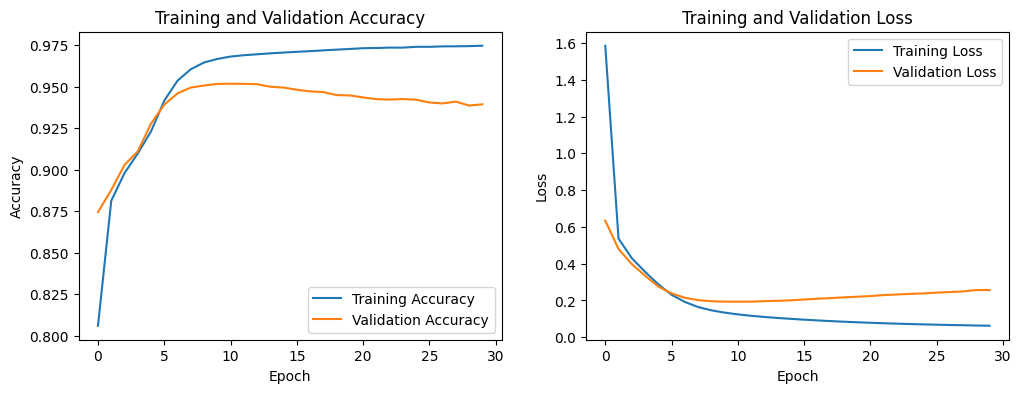

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation metrics from history
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Print the final training and testing accuracy and loss
print(f'Final Training Accuracy: {acc[-1]:.4f}')
print(f'Final Testing Accuracy: {val_acc[-1]:.4f}')
print(f'Final Training Loss: {loss[-1]:.4f}')
print(f'Final Testing Loss: {val_loss[-1]:.4f}')

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [3]:
!pip install keras-tuner

import keras_tuner as kt
import tensorflow as tf # Import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming X_train, y_train, X_test, y_test, max_len, word_tokenizer, and tag_tokenizer are already defined from the previous cell

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(word_tokenizer.word_index) + 1, output_dim=hp.Int('embedding_output_dim', min_value=16, max_value=128, step=16), input_length=max_len))

    # Add RNN layers
    for i in range(hp.Int('num_rnn_layers', min_value=1, max_value=4, step=1)):
        model.add(SimpleRNN(hp.Int(f'rnn_units_{i}', min_value=16, max_value=128, step=16), return_sequences=True))

    model.add(TimeDistributed(Dense(len(tag_tokenizer.word_index) + 1, activation='softmax')))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10, # You can adjust this
                     factor=3,
                     directory='my_dir', # Directory to store results
                     project_name='rnn_pos_tuning') # Project name

# Start the search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test)) # You can adjust the number of epochs

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of RNN layers is {best_hps.get('num_rnn_layers')}.
The optimal embedding output dimension is {best_hps.get('embedding_output_dim')}.
The optimal number of units in the RNN layers are: {[best_hps.get(f'rnn_units_{i}') for i in range(best_hps.get('num_rnn_layers'))]}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Best model test accuracy: {accuracy}")

Trial 30 Complete [00h 02m 44s]
val_accuracy: 0.9553659558296204

Best val_accuracy So Far: 0.9574502110481262
Total elapsed time: 00h 45m 57s

The optimal number of RNN layers is 1.
The optimal embedding output dimension is 32.
The optimal number of units in the RNN layers are: [32].
The optimal learning rate for the optimizer is 0.01.

64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9589 - loss: 0.1409
Best model test accuracy: 0.9574502110481262


In [5]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions from the best model
y_pred = best_model.predict(X_test)

# Convert predictions and true labels from one-hot encoding to class indices
y_pred_classes = np.argmax(y_pred, axis=2).flatten()
y_test_classes = np.argmax(y_test, axis=2).flatten()

# Get the list of tags from the tokenizer, skipping the padding index (0)
# We need to map the token indices back to the original tag strings for the classification report
tag_labels = [tag_tokenizer.index_word[i] for i in sorted(tag_tokenizer.word_index.keys())]

# Filter out the padding (index 0) from both predicted and true labels for the report
# The classification report should not include metrics for the padding class
non_padding_indices = y_test_classes != 0
y_test_classes_filtered = y_test_classes[non_padding_indices]
y_pred_classes_filtered = y_pred_classes[non_padding_indices]

# Generate and print the classification report
# The target_names should correspond to the actual tags, excluding the padding.
# We need to adjust the labels used in the classification report to match the filtered data.
# The labels should be the original indices *before* filtering out padding, excluding 0.
report_labels = [i for i in sorted(tag_tokenizer.word_index.keys())] # Original indices excluding 0
report_target_names = [tag_tokenizer.index_word[i] for i in report_labels] # Corresponding tag strings

print("Classification Report (excluding padding):")
print(classification_report(y_test_classes_filtered, y_pred_classes_filtered, labels=report_labels, target_names=report_target_names, zero_division=0))

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report (excluding padding):
              precision    recall  f1-score   support

          NN       0.84      0.94      0.89      9263
         NNP       0.86      0.79      0.82      2561
         SYM       0.71      0.98      0.82      2424
          VM       0.61      0.82      0.70      2298
          JJ       0.71      0.79      0.75      2261
        VAUX       0.70      0.83      0.76      1668
       PUNCT       0.30      0.01      0.02       987
          RB       0.62      0.71      0.66       927
          CC       0.86      0.94      0.90       966
         DEM       0.89      0.90      0.90       904
         PSP       0.61      0.57      0.58       885
         PRP       0.71      0.83      0.76       747
          QC       0.68      0.80      0.74       686
          VB       0.00      0.00      0.00       500
         ADJ       0.00      0.00      0.00       447
         ADV       0.11      0.01      0.01       300

In [6]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_test_classes_filtered and y_pred_classes_filtered are available from the previous cell

# Get the classification report as a dictionary
report_dict = classification_report(y_test_classes_filtered, y_pred_classes_filtered, output_dict=True, zero_division=0)

# Extract the weighted average f1-score
overall_f1_score = report_dict['weighted avg']['f1-score']

# Print the overall f1-score
print(f"Overall F1 Score (weighted average): {overall_f1_score:.4f}")

Overall F1 Score (weighted average): 0.7114
